In [1]:
from basemap.pumap.parametric_umap import ParametricUMAP

/Users/enjalot/code/latent-basemap/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the trained model from disk
# model = ParametricUMAP.load("data/basemap-lancedb-fineweb-edu-100k-32768-1-0.0001")
model = ParametricUMAP.load("data/basemap-lancedb-dataisplural-4096-10-0.0001")


/Users/enjalot/code/latent-basemap/basemap/pumap/parametric_umap/core.py:462: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(path, map_location=device)

In [4]:
from basemap.lancedb_loader import LanceDBLoader
import numpy as np

# Configure dataset path and table name
# DATASET = "/Users/enjalot/latent-scope-demo/ls-fineweb-edu-100k/lancedb"
DATASET = "/Users/enjalot/latent-scope-demo/ls-dataisplural/lancedb"
TABLE = "scopes-001"

# Initialize the LanceDB loader
X_train = LanceDBLoader(db_name=DATASET, table_name=TABLE, columns=["vector"])

# Convert to numpy array
print("Converting to numpy array...")
X = np.asarray(X_train).astype(np.float32)
print("Shape:", X.shape)


Converting to numpy array...
SHAPE (1965, 768)
DATA (1965, 768)
NP VECTOR (1965, 768)
Shape: (1965, 768)


In [5]:
xy = model.transform(X)

In [6]:
# Normalize xy to [-1, 1] range
xy_min = np.min(xy, axis=0)
xy_max = np.max(xy, axis=0)
xy_norm = 2 * (xy - xy_min) / (xy_max - xy_min) - 1
xy_norm


array([[-0.27147043,  0.24522448],
       [-0.63479936,  0.4366933 ],
       [-0.45978492, -0.5914266 ],
       ...,
       [-0.1854378 ,  0.42760003],
       [ 0.7685363 ,  0.28807247],
       [ 0.16018808, -0.33533233]], shape=(1965, 2), dtype=float32)

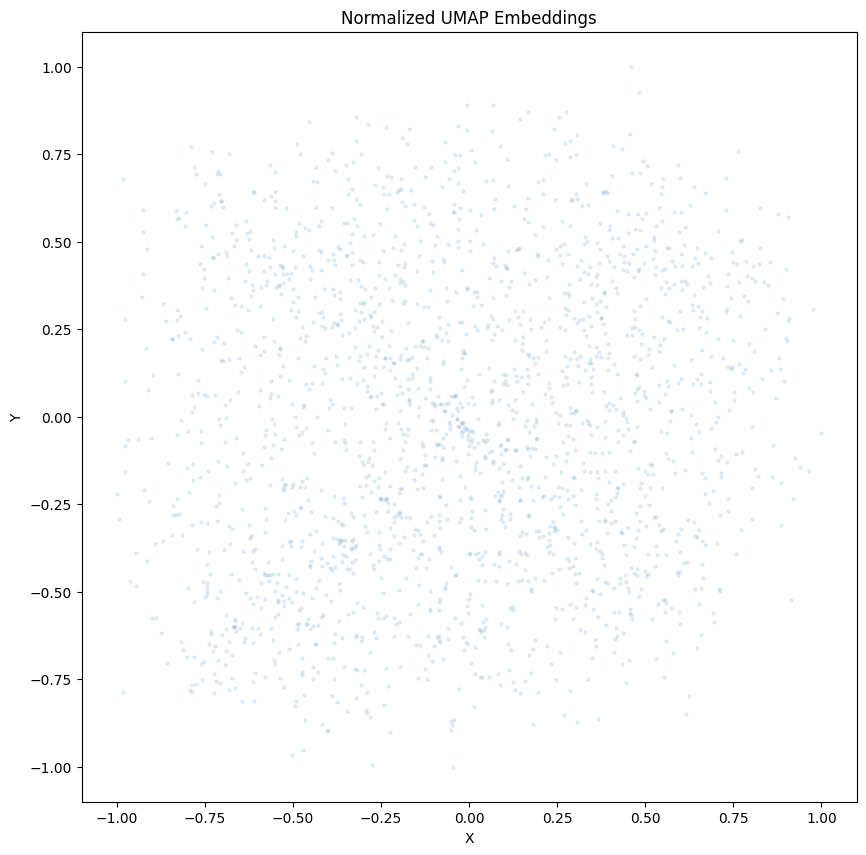

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(xy_norm[:, 0], xy_norm[:, 1], alpha=0.1, s=5)
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Normalized UMAP Embeddings')
plt.show()


In [28]:
from sklearn.manifold import trustworthiness
trust_parametric = trustworthiness(X, xy, n_neighbors=15)
print("Parametric UMAP Trustworthiness:", trust_parametric)

Parametric UMAP Trustworthiness: 0.6367092851296592


In [18]:
import lancedb
db = lancedb.connect(DATASET)
table = db.open_table(TABLE)
txy = table.to_lance().take(indices=np.arange(len(X)), columns=["x","y"])
sx = txy[0].to_numpy()
sy = txy[1].to_numpy()
sxy = np.column_stack((sx, sy))

In [19]:
sxy

array([[-0.4752922 ,  0.57942486],
       [ 0.10739529, -0.34621572],
       [ 0.17594552, -0.7489936 ],
       ...,
       [ 0.38491774, -0.07738221],
       [ 0.59358275,  0.5615145 ],
       [-0.56803846,  0.9543688 ]], shape=(1965, 2), dtype=float32)

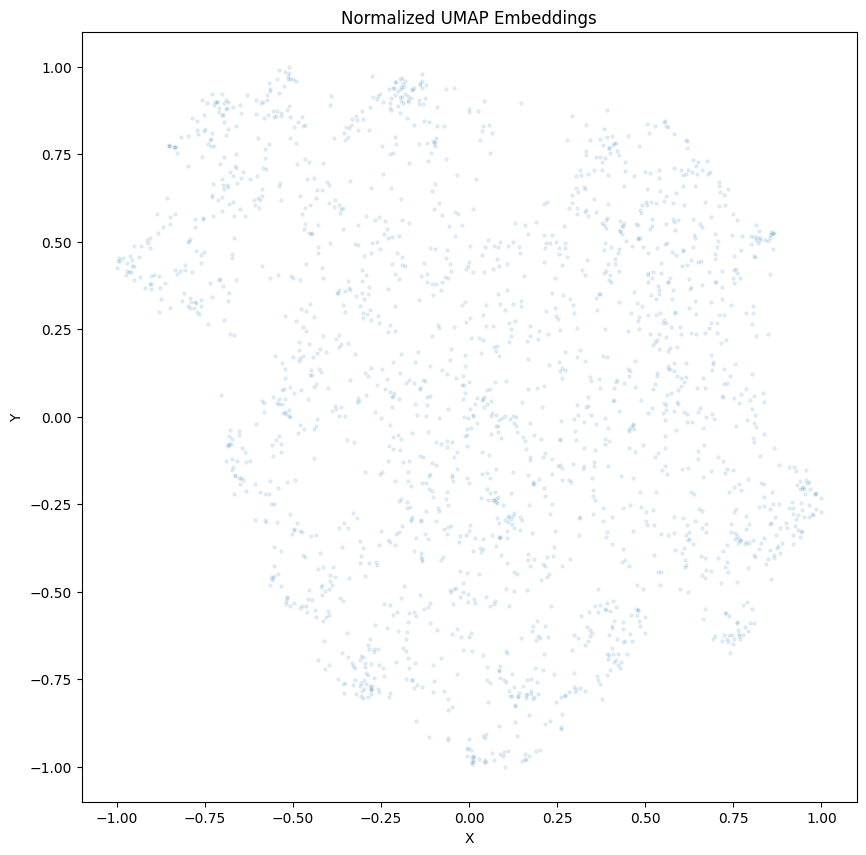

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(sxy[:, 0], sxy[:, 1], alpha=0.1, s=5)
plt.xlabel('X')
plt.ylabel('Y') 
plt.title('Normalized UMAP Embeddings')
plt.show()


In [26]:
trust_standard = trustworthiness(X, sxy, n_neighbors=15)

print("Standard UMAP Trustworthiness:", trust_standard)

Standard UMAP Trustworthiness: 0.8671491052219191
